<a href="https://colab.research.google.com/github/nitinaarora/Twitter_RealOrFake_Tensorflow_GLove_LSTM/blob/master/Twitter_RealOrNot_Tensorflow2.0_Glove_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan V2 (27 sept) - With Gove


*   get data from kaggle
*   Analyze data - visually and table view
*   Clean data -- remove stop words in next version
*   Split data if not split already
*   Simple Tokenization/Padding -> Then Glove OR Word2vec *** current focus
*   Create model, train and evaluate
*   Evaluate Accuracy
*   Improve
*   List item
*   List item

in first version, lets not use keyword and location features. Focus would be only text and target


## Glove implementation


*   Get glove vector file from standford portal based on type
*   unzip in local and upload into colab
*   create dict from glove file for word and vector value
*   create metrics only for words within our vocab
*   pass this metrics as weight parameter in Embedding layer
*   Set Trainable - False in Embedding layer


## Pre-processing Improvements


*   concatenate keyword column into txt column.. it might be useful
*   Remove unnecessary text/words from "text" column like :- HTTP Link, punctuation, emojis, stopwords


---

## Learning

*  word_index will keep all words in itself regardless of vocab_size...vocab_size only come in picture when we use tokenixer to tranform like tk.texts_to_sequences...this is beacuse in traget text, most common words might be different so it keep all words to see most frequent words






















In [5]:
##import packanges
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout,Flatten, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [6]:
!pip install -q kaggle

In [7]:

! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c nlp-getting-started

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
df_train = pd.read_csv('/content/train.csv',decimal=',')
df_test = pd.read_csv('/content/test.csv',decimal=',')

In [11]:
df_train.count()
df_test.count()

id          3263
keyword     3237
location    2158
text        3263
dtype: int64

Result Compariosn
V1 )
full trainset, adam, binary_crossentropy
model - emb, lstm(64), flatten, sigmoid
epochs 100
accuracy .80
chances of overfitting


In [31]:

## pre-processing improvements


import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
import re
import spacy
sp = spacy.load('en_core_web_sm')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemma= WordNetLemmatizer()

def clean_data(text):
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)
    
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
    
    #Remove stopwords
    all_stopwords = sp.Defaults.stop_words
    text_tokens = word_tokenize(text)
    tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
      
    #lemmatization
    text= [lemma.lemmatize(w) for w in tokens_without_sw]
    text= ' '.join(text)
  
    #remove double spaces 
    text = re.sub('\s+', ' ',text)
    return (text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [32]:
df_train['text'] = df_train['text'].apply(clean_data)

In [33]:
x_train, y_train = df_train['text'], df_train['target']
x_test = df_test['text']

In [34]:
xtrain,xval, ytrain,yval = train_test_split(x_train,y_train, test_size=.3)

In [14]:
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)

(5329,)
(5329,)
(2284,)
(2284,)


In [35]:
## learning...-->> word_index will keep all words in itself regardless of vocab_size...vocab_size only come in picture when we use tokenixer to tranform like tk.texts_to_sequences....
## this is beacuse in traget text, most common words might be different so it keep all words to see most frequent words
vocab_size =25000
oovtoken ='<OOV>'

def tokenize_padding(train_text,val_text):
  tk = Tokenizer(num_words=vocab_size,oov_token=oovtoken)
  tokenizer_train = tk.fit_on_texts(train_text)
  word_index = tk.word_index
  train_input_sequence = tk.texts_to_sequences(train_text)
  train_input_sequence_padded = pad_sequences(train_input_sequence,padding='pre',truncating='pre')
  local_max_len = train_input_sequence_padded.shape[-1]

  val_input_sequence = tk.texts_to_sequences(val_text)
  val_input_sequence_padded = pad_sequences(val_input_sequence,padding='pre',maxlen=local_max_len,truncating='pre')
  return train_input_sequence_padded,val_input_sequence_padded,word_index

In [36]:
x_train_padded, x_valid_padded,word_index = tokenize_padding(xtrain,xval)
x_train_padded_2,x_test_padded ,word_index= tokenize_padding(xtrain,x_test)

In [37]:
print(x_train_padded.shape)
print(x_valid_padded.shape)

(5329, 21)
(2284, 21)


In [38]:
max_len = x_train_padded.shape[-1]
print(max_len)

21


In [39]:
print(x_train_padded[0])

[   0    0    0    0    0    0    0    0    0    0   67 4437  268 4438
 1371 4439  440  318 4440 4441 4442]


In [20]:
## Glove implementation
import numpy as np


#lets make function for dictonary
gval_file ='/content/glove.twitter.27B.200d.txt'
embedding_dim =200
embedding_index ={} #dict

with open(gval_file) as f:
  for line in f:
    values = line.split()
    word = values[0]
    #vector = values[1:] ## not added as array, just to check
    vector = np.asarray(values[1:], dtype='float32');
    embedding_index[word] = vector

In [40]:
embedding_metrics = np.zeros((vocab_size,embedding_dim))

#now lets create metric only for our vocab

for word,i in word_index.items():
  emb_vector = embedding_index.get(word)
  if(emb_vector is not None):
    embedding_metrics[i] = emb_vector

In [22]:
#embedding_metrics.shape
embedding_metrics[3]
#print(word_index)


array([-1.16910003e-01, -6.14850000e-02, -4.63959992e-01,  2.07760006e-01,
       -3.34069997e-01, -3.70310009e-01, -4.50610012e-01,  1.80810004e-01,
       -1.99919999e-01, -1.59909993e-01, -2.34239995e-01,  6.89380020e-02,
       -5.76179996e-02,  1.82530001e-01,  1.88710004e-01,  2.35440001e-01,
        3.83850008e-01,  2.39539996e-01, -3.05669993e-01, -3.21649998e-01,
        6.77129999e-02, -2.94030011e-01,  1.23439997e-01, -1.09880000e-01,
       -2.97069997e-01, -1.07780004e+00, -1.72619998e-01, -6.57100007e-02,
        5.23130000e-01,  2.94699997e-01, -8.96510035e-02, -7.43009984e-01,
       -2.94940006e-02, -6.39680028e-02,  1.56869993e-01,  6.09200001e-01,
       -1.88600004e-01,  1.02119997e-01, -3.71300012e-01, -2.33419999e-01,
       -4.88299996e-01,  6.43989980e-01,  2.46340007e-01,  1.00460000e-01,
       -4.94789988e-01,  4.81950015e-01, -4.70569998e-01, -5.02680004e-01,
       -2.52810001e-01, -3.03779989e-01,  3.08140010e-01,  2.90490001e-01,
        1.11000001e+00,  

In [55]:

model = tf.keras.models.Sequential([
                                     tf.keras.layers.Embedding(vocab_size,embedding_dim,
                                                              input_length= max_len
                                                              , weights=[embedding_metrics],trainable = False
                                                              ),
                                    tf.keras.layers.Dropout(.4),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True )),
                                    #tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                    
                                    #tf.keras.layers.GlobalAvgPool1D(),
                                    #tf.keras.layers.Flatten(),
                                    #tf.keras.layers.LSTM(64),
                                    tf.keras.layers.Dense(200, activation='relu'),
                                    #tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])
learningratesch = tf.keras.callbacks.LearningRateScheduler(lambda epochs: 1e-5*10**(epochs/20))
r2 = model.fit(x=x_train_padded,y=ytrain, 
               validation_data=(x_valid_padded,yval), 
               epochs=100, 
               verbose=2,
               callbacks=[learningratesch]
               )

Epoch 1/100
167/167 - 3s - loss: 0.6852 - accuracy: 0.6099 - val_loss: 0.6797 - val_accuracy: 0.6165
Epoch 2/100
167/167 - 2s - loss: 0.6737 - accuracy: 0.6326 - val_loss: 0.6647 - val_accuracy: 0.6475
Epoch 3/100
167/167 - 2s - loss: 0.6532 - accuracy: 0.6787 - val_loss: 0.6345 - val_accuracy: 0.7062
Epoch 4/100
167/167 - 2s - loss: 0.6140 - accuracy: 0.7390 - val_loss: 0.5711 - val_accuracy: 0.7701
Epoch 5/100
167/167 - 2s - loss: 0.5467 - accuracy: 0.7673 - val_loss: 0.4941 - val_accuracy: 0.7837
Epoch 6/100
167/167 - 2s - loss: 0.4976 - accuracy: 0.7780 - val_loss: 0.4684 - val_accuracy: 0.7881
Epoch 7/100
167/167 - 2s - loss: 0.4792 - accuracy: 0.7812 - val_loss: 0.4594 - val_accuracy: 0.7925
Epoch 8/100
167/167 - 2s - loss: 0.4772 - accuracy: 0.7833 - val_loss: 0.4530 - val_accuracy: 0.7982
Epoch 9/100
167/167 - 2s - loss: 0.4614 - accuracy: 0.7925 - val_loss: 0.4482 - val_accuracy: 0.8030
Epoch 10/100
167/167 - 2s - loss: 0.4560 - accuracy: 0.7958 - val_loss: 0.4458 - val_accura

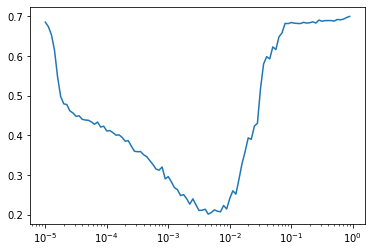

In [57]:
plt.semilogx(r2.history['lr'],r2.history['loss'])
#plt.axis([1e-4,1e-2,0,.2])

In [58]:
#recompile after picking correct learning rate
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(vocab_size,embedding_dim,
                                                              input_length= max_len
                                                              , weights=[embedding_metrics],trainable = False
                                                              ),
                                    tf.keras.layers.Dropout(.4),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True )),
                                    #tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                    
                                    #tf.keras.layers.GlobalAvgPool1D(),
                                    #tf.keras.layers.Flatten(),
                                    #tf.keras.layers.LSTM(64),
                                    tf.keras.layers.Dense(200, activation='relu'),
                                    #tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='binary_crossentropy', metrics=['accuracy'])
r3 = model.fit(x=x_train_padded,y=ytrain, 
               validation_data=(x_valid_padded,yval), 
               epochs=20, 
               verbose=2
               )

Epoch 1/20
167/167 - 3s - loss: 0.5227 - accuracy: 0.7502 - val_loss: 0.4498 - val_accuracy: 0.8012
Epoch 2/20
167/167 - 2s - loss: 0.4474 - accuracy: 0.7966 - val_loss: 0.4393 - val_accuracy: 0.8060
Epoch 3/20
167/167 - 2s - loss: 0.4348 - accuracy: 0.8067 - val_loss: 0.4315 - val_accuracy: 0.8078
Epoch 4/20
167/167 - 2s - loss: 0.4189 - accuracy: 0.8157 - val_loss: 0.4416 - val_accuracy: 0.8056
Epoch 5/20
167/167 - 2s - loss: 0.4003 - accuracy: 0.8227 - val_loss: 0.4364 - val_accuracy: 0.8025
Epoch 6/20
167/167 - 2s - loss: 0.3905 - accuracy: 0.8304 - val_loss: 0.4336 - val_accuracy: 0.8074
Epoch 7/20
167/167 - 2s - loss: 0.3785 - accuracy: 0.8313 - val_loss: 0.4522 - val_accuracy: 0.8039
Epoch 8/20
167/167 - 2s - loss: 0.3702 - accuracy: 0.8364 - val_loss: 0.4403 - val_accuracy: 0.7990
Epoch 9/20
167/167 - 2s - loss: 0.3561 - accuracy: 0.8495 - val_loss: 0.4488 - val_accuracy: 0.8025
Epoch 10/20
167/167 - 2s - loss: 0.3392 - accuracy: 0.8551 - val_loss: 0.4829 - val_accuracy: 0.7973

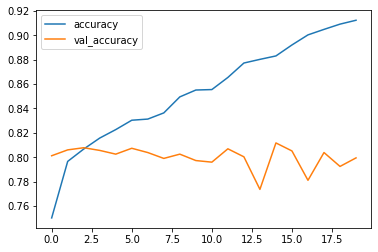

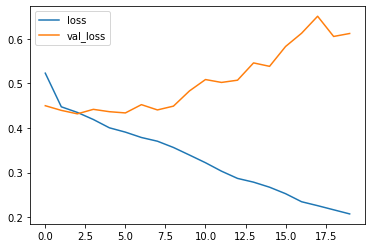

In [59]:
plt.plot(r3.history['accuracy'],label='accuracy')
plt.plot(r3.history['val_accuracy'], label ='val_accuracy')
plt.legend()
plt.show()
plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
sample_submission = pd.read_csv("/content/sample_submission.csv")

In [ ]:
sample_submission["target"] = model.predict_classes(x_test_padded)

In [ ]:
sample_submission.head(100)

In [ ]:
sample_submission.to_csv("submission.csv", index=False)